In [13]:
import pandas as pd
import numpy as np
import torch
from preprocessing.feature_engineering import FeatureEngineering
from preprocessing.Resampling import Resampling
from graph.graph_construction import GraphConstruction
from models.GNNs import GraphSAGE, GAT, GraphSAGE1, GraphSAGE2, GraphSAGE3
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch_geometric.nn import to_hetero
from torch_geometric.loader import HGTLoader
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm

In [2]:
dataset = pd.read_csv('C:/Users/ruben/OneDrive/Desktop/Datasets/original_dataset.csv')

# Apply feature engineering on the dataset
fe = FeatureEngineering(dataset)
processed_dataset = fe.apply_feature_engineering()

# Apply resampling on the dataset
resampler = Resampling(processed_dataset, test_size=0.4, random_state=42)
final_dataset = resampler.apply_resampling()

Feature engineering completed.
Fraud rate in training set before resampling: 0.54%
Fraud rate in testing set: 0.62%
Fraud rate in training set after resampling: 50.00%
Fraud rate in testing set after resampling: 0.62%
Length of training set: 953192
Length of testing set: 198889


In [3]:
final_dataset.head()
final_dataset.to_csv('C:/Users/ruben/OneDrive/Desktop/Datasets/final_dataset.csv', index=False)

In [14]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [15]:
final_dataset = pd.read_csv('C:/Users/ruben/OneDrive/Desktop/Datasets/final_dataset.csv')

# Percentage in Test and Val set is not the same because there is no stratified split performed
graph_constructor = GraphConstruction(final_dataset)
data = graph_constructor.apply_graph_construction()

Fraud Percentage in Train Mask: 50.00%
Fraud Percentage in Test Mask: 0.61%
Fraud Percentage in Val Mask: 0.63%
Graph Construction Successful!


In [16]:
print(data)

HeteroData(
  transaction={
    x=[1152081, 7],
    y=[1152081],
    num_classes=2,
    train_mask=[1152081],
    test_mask=[1152081],
    val_mask=[1152081],
  },
  client={ x=[983, 5] },
  merchant={ x=[693, 1] },
  (client, pays, transaction)={ edge_index=[2, 1152081] },
  (transaction, received by, merchant)={ edge_index=[2, 1152081] },
  (transaction, rev_pays, client)={ edge_index=[2, 1152081] },
  (merchant, rev_received by, transaction)={ edge_index=[2, 1152081] }
)


In [17]:
model = GraphSAGE3(in_channels=data.num_features, hidden_dim=128, embedding_dim=64, output_dim=1, num_layers=3, dropout_rate=0.5, sage_aggr='mean')
model = to_hetero(model, data.metadata())
data, model = data.to(device), model.to(device)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.BCEWithLogitsLoss()

c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\nn\to_hetero_transformer.py:165: UserWarning: The type 'received by' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\nn\to_hetero_transformer.py:165: UserWarning: The type 'rev_received by' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(


In [18]:
@torch.no_grad()
def init_params():
    model(data.x_dict, data.edge_index_dict)

In [19]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)['transaction']
    loss = criterion(out.squeeze(1)[data['transaction'].train_mask], data['transaction'].y[data['transaction'].train_mask].float())
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

In [20]:
@torch.no_grad()
def test(mask):
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)['transaction']
    loss = criterion(out.squeeze(1)[mask], data['transaction'].y[mask].float())
    y_pred_proba = torch.sigmoid(out[mask]).cpu().numpy()
    y_true = data['transaction'].y[mask].cpu().numpy()
    return y_true, y_pred_proba, loss.item()

In [21]:
init_params()

training_losses = []
validation_losses = []

consecutive_increases = 0
max_consecutive_increases = 5

for epoch in range(50):
    loss = train()
    print(f'Epoch {epoch+1:02d}, Training loss: {loss:.4f}')
    training_losses.append(loss)

    y_val, y_val_pred_proba, val_loss = test(data['transaction'].val_mask)
    print(f'Epoch {epoch+1:02d}, Validation loss: {val_loss:.4f}')
    validation_losses.append(val_loss)

    ap_val = average_precision_score(y_val, y_val_pred_proba)
    roc_val = roc_auc_score(y_val, y_val_pred_proba)

    print(f'Epoch {epoch+1:02d}, Average precision validation set: {ap_val:.2f}, ROC AUC validation set: {roc_val:.2f}')

    # Check for early stopping
    if epoch > 0 and val_loss >= validation_losses[-2]:
        consecutive_increases += 1
        if consecutive_increases >= max_consecutive_increases:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    else:
        consecutive_increases = 0

Epoch 01, Training loss: 0.7152
Epoch 01, Validation loss: 0.1681
Epoch 01, Average precision validation set: 0.04, ROC AUC validation set: 0.71
Epoch 02, Training loss: 1.0787
Epoch 02, Validation loss: 0.7003
Epoch 02, Average precision validation set: 0.01, ROC AUC validation set: 0.57
Epoch 03, Training loss: 0.6921
Epoch 03, Validation loss: 0.7656
Epoch 03, Average precision validation set: 0.02, ROC AUC validation set: 0.61
Epoch 04, Training loss: 0.6995
Epoch 04, Validation loss: 0.6704
Epoch 04, Average precision validation set: 0.03, ROC AUC validation set: 0.70
Epoch 05, Training loss: 0.6916
Epoch 05, Validation loss: 0.6542
Epoch 05, Average precision validation set: 0.02, ROC AUC validation set: 0.73
Epoch 06, Training loss: 0.6915
Epoch 06, Validation loss: 0.6508
Epoch 06, Average precision validation set: 0.03, ROC AUC validation set: 0.75
Epoch 07, Training loss: 0.6900
Epoch 07, Validation loss: 0.6604
Epoch 07, Average precision validation set: 0.08, ROC AUC valida

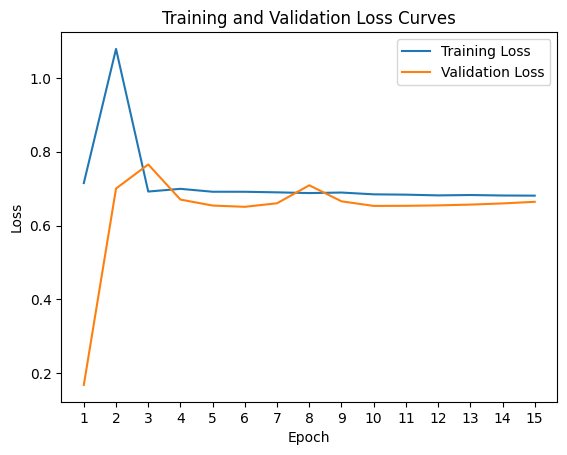

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, 16), training_losses, label='Training Loss')
plt.plot(range(1, 16), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Set x-axis to have increments of 1
plt.xticks(range(1, 16))

plt.show()

In [24]:
# Evaluate the model on the test set
y_test, y_test_pred_proba, test_loss = test(data['transaction'].test_mask)
ap_test = average_precision_score(y_test, y_test_pred_proba)
roc_test = roc_auc_score(y_test, y_test_pred_proba)

print(f'Average precision testing set: {ap_test:.4f}, ROC AUC testing set: {roc_test:.4f}')

Average precision testing set: 0.0676, ROC AUC testing set: 0.7751
